In [1]:
import numpy as np
from scipy.stats import t

In [2]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)#, parser='auto')
X = X.values

X = X / 255. #normalization to [0,1]

y = X

print(X.shape)
print(y.shape)

(70000, 784)
(70000, 784)


In [3]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=123)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123)

del X_temp, y_temp, X, y

In [4]:
def ssim(X_pred, X_test, K1=0.01, K2=0.03):

    X_pred = X_pred.astype(np.float64)
    X_test = X_test.astype(np.float64)

    max_val = max(X_pred.max(), X_test.max())
    min_val = min(X_pred.min(), X_test.min())
    L = max_val - min_val # L is the dynamic range of the data

    C1 = (K1 * L) ** 2
    C2 = (K2 * L) ** 2

    mu_x = X_pred.mean()
    mu_y = X_test.mean()

    sigma_x = ((X_pred - mu_x) ** 2).mean()
    sigma_y = ((X_test - mu_y) ** 2).mean()
    sigma_xy = ((X_pred - mu_x) * (X_test - mu_y)).mean()

    numerator = (2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)
    denominator = (mu_x ** 2 + mu_y ** 2 + C1) * (sigma_x + sigma_y + C2)

    ssim_value = numerator / denominator
    return ssim_value

In [5]:
##########################
### VAE
##########################
def sigmoid(z):
    return 1. / (1. + np.exp(-z))

def relu(z): #relu
    return np.maximum(0, z)

def relu_deriv(z):
    return np.where(z > 0, 1, 0)


class VAE:

    def __init__(self, input_size, hidden_size1, hidden_size2, latent_size, random_seed=123):

        rng = np.random.RandomState(random_seed)

        # encoder weights
        self.W_e1 = rng.normal(
            loc=0.0, scale=0.1, size=(hidden_size1, input_size))
        self.b_e1 = np.zeros((1, hidden_size1))

        self.W_e2 = rng.normal(
            loc=0.0, scale=0.1, size=(hidden_size2, hidden_size1))
        self.b_e2 = np.zeros((1, hidden_size2))

        self.W_e3 = rng.normal(
            loc=0.0, scale=0.1, size=(latent_size * 2, hidden_size2))
        self.b_e3 = np.zeros((1, latent_size * 2))


        # decoder weights
        self.W_d1 = rng.normal(
            loc=0.0, scale=0.1, size=(hidden_size2, latent_size))
        self.b_d1 = np.zeros((1, hidden_size2))

        self.W_d2 = rng.normal(
            loc=0.0, scale=0.1, size=(hidden_size1, hidden_size2))
        self.b_d2 = np.zeros((1, hidden_size1))

        self.W_d3 = rng.normal(
            loc=0.0, scale=0.1, size=(input_size, hidden_size1))
        self.b_d3 = np.zeros((1, input_size))

    def encoder(self, x):
        z_e1 = x @ self.W_e1.T + self.b_e1
        a_e1 = relu(z_e1) # activation

        z_e2 = a_e1 @ self.W_e2.T + self.b_e2
        a_e2 = relu(z_e2) # activation

        mu_logvar = a_e2 @ self.W_e3.T + self.b_e3 # linear
        mu, logvar = np.split(mu_logvar, 2, axis=1)

        return z_e1, a_e1, z_e2, a_e2, mu, logvar

    def reparameterize(self, mu, logvar):
        std = np.exp(0.5 * logvar)
        eps = np.random.normal(size=mu.shape)

        latent = mu + eps * std

        return latent, eps

    def decoder(self, latent):
        z_d1 = latent @ self.W_d1.T + self.b_d1
        a_d1 = relu(z_d1) # activation

        z_d2 = a_d1 @ self.W_d2.T + self.b_d2
        a_d2 = relu(z_d2) # activation

        z_d3 = a_d2 @ self.W_d3.T + self.b_d3
        recon_x = sigmoid(z_d3) # sigmoid

        return z_d1, a_d1, z_d2, a_d2, recon_x

    def forward(self, x):
        z_e1, a_e1, z_e2, a_e2, mu, logvar = self.encoder(x)
        latent, eps = self.reparameterize(mu, logvar)
        z_d1, a_d1, z_d2, a_d2, recon_x = self.decoder(latent)

        return z_e1, a_e1, z_e2, a_e2, mu, logvar, latent, z_d1, a_d1, z_d2, a_d2, recon_x, eps

In [6]:
##########################
### t_prior_VAE
##########################
def sigmoid(z):
    return 1. / (1. + np.exp(-z))

def relu(z): #relu
    return np.maximum(0, z)

def relu_deriv(z):
    return np.where(z > 0, 1, 0)


class t_prior_VAE:

    def __init__(self, input_size, hidden_size1, hidden_size2, latent_size, df, random_seed=123):

        rng = np.random.RandomState(random_seed)
        self.df = df # degree of freedom of prior t-distribution

        # encoder weights
        self.W_e1 = rng.normal(
            loc=0.0, scale=0.1, size=(hidden_size1, input_size))
        self.b_e1 = np.zeros((1, hidden_size1))

        self.W_e2 = rng.normal(
            loc=0.0, scale=0.1, size=(hidden_size2, hidden_size1))
        self.b_e2 = np.zeros((1, hidden_size2))

        self.W_e3 = rng.normal(
            loc=0.0, scale=0.1, size=(latent_size * 2, hidden_size2))
        self.b_e3 = np.zeros((1, latent_size * 2))


        # decoder weights
        self.W_d1 = rng.normal(
            loc=0.0, scale=0.1, size=(hidden_size2, latent_size))
        self.b_d1 = np.zeros((1, hidden_size2))

        self.W_d2 = rng.normal(
            loc=0.0, scale=0.1, size=(hidden_size1, hidden_size2))
        self.b_d2 = np.zeros((1, hidden_size1))

        self.W_d3 = rng.normal(
            loc=0.0, scale=0.1, size=(input_size, hidden_size1))
        self.b_d3 = np.zeros((1, input_size))

    def encoder(self, x):
        z_e1 = x @ self.W_e1.T + self.b_e1
        a_e1 = relu(z_e1) # activation

        z_e2 = a_e1 @ self.W_e2.T + self.b_e2
        a_e2 = relu(z_e2) # activation

        mu_logvar = a_e2 @ self.W_e3.T + self.b_e3 # linear
        mu, logvar = np.split(mu_logvar, 2, axis=1)

        return z_e1, a_e1, z_e2, a_e2, mu, logvar

    def reparameterize(self, mu, logvar):
        std = np.exp(0.5 * logvar)
        #eps = np.random.normal(size=mu.shape)
        eps = t.rvs(df=self.df, size=mu.shape) # student's t iid matrix with degree of freedom v+n

        latent = mu + eps * std

        return latent, eps

    def decoder(self, latent):
        z_d1 = latent @ self.W_d1.T + self.b_d1
        a_d1 = relu(z_d1) # activation

        z_d2 = a_d1 @ self.W_d2.T + self.b_d2
        a_d2 = relu(z_d2) # activation

        z_d3 = a_d2 @ self.W_d3.T + self.b_d3
        recon_x = sigmoid(z_d3) # sigmoid

        return z_d1, a_d1, z_d2, a_d2, recon_x

    def forward(self, x):
        z_e1, a_e1, z_e2, a_e2, mu, logvar = self.encoder(x)
        latent, eps = self.reparameterize(mu, logvar)
        z_d1, a_d1, z_d2, a_d2, recon_x = self.decoder(latent)

        return z_e1, a_e1, z_e2, a_e2, mu, logvar, latent, z_d1, a_d1, z_d2, a_d2, recon_x, eps

In [7]:
import pickle

with open('VAE_MNIST.p', 'rb') as file1:
    model1 = pickle.load(file1)
    train_loss1 = pickle.load(file1)
    valid_loss1 = pickle.load(file1)

with open('t_prior_VAE_MNIST.p', 'rb') as file2:
    model2 = pickle.load(file2)
    train_loss2 = pickle.load(file2)
    valid_loss2 = pickle.load(file2)

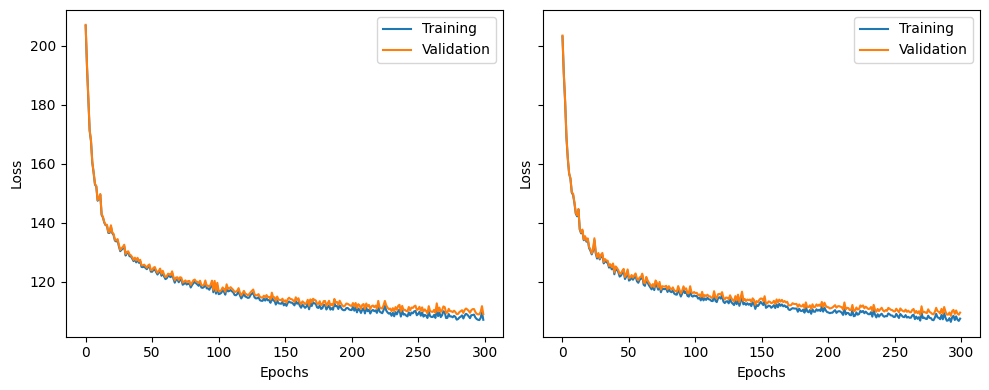

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,4), nrows=1, ncols=2, sharex=True, sharey=True)
for i in range(2):
    ax[i].plot(range(len(eval(f'train_loss{i+1}'))), eval(f'train_loss{i+1}'), label='Training')
    ax[i].plot(range(len(eval(f'valid_loss{i+1}'))), eval(f'valid_loss{i+1}'), label='Validation')
    ax[i].set_ylabel('Loss')
    ax[i].set_xlabel('Epochs')
    ax[i].legend(loc='upper right')
plt.tight_layout()
plt.show()

# data reconstruction

In [9]:
samples=np.arange(0,10) # fixed sample
samples=np.random.randint(0,10000,10)

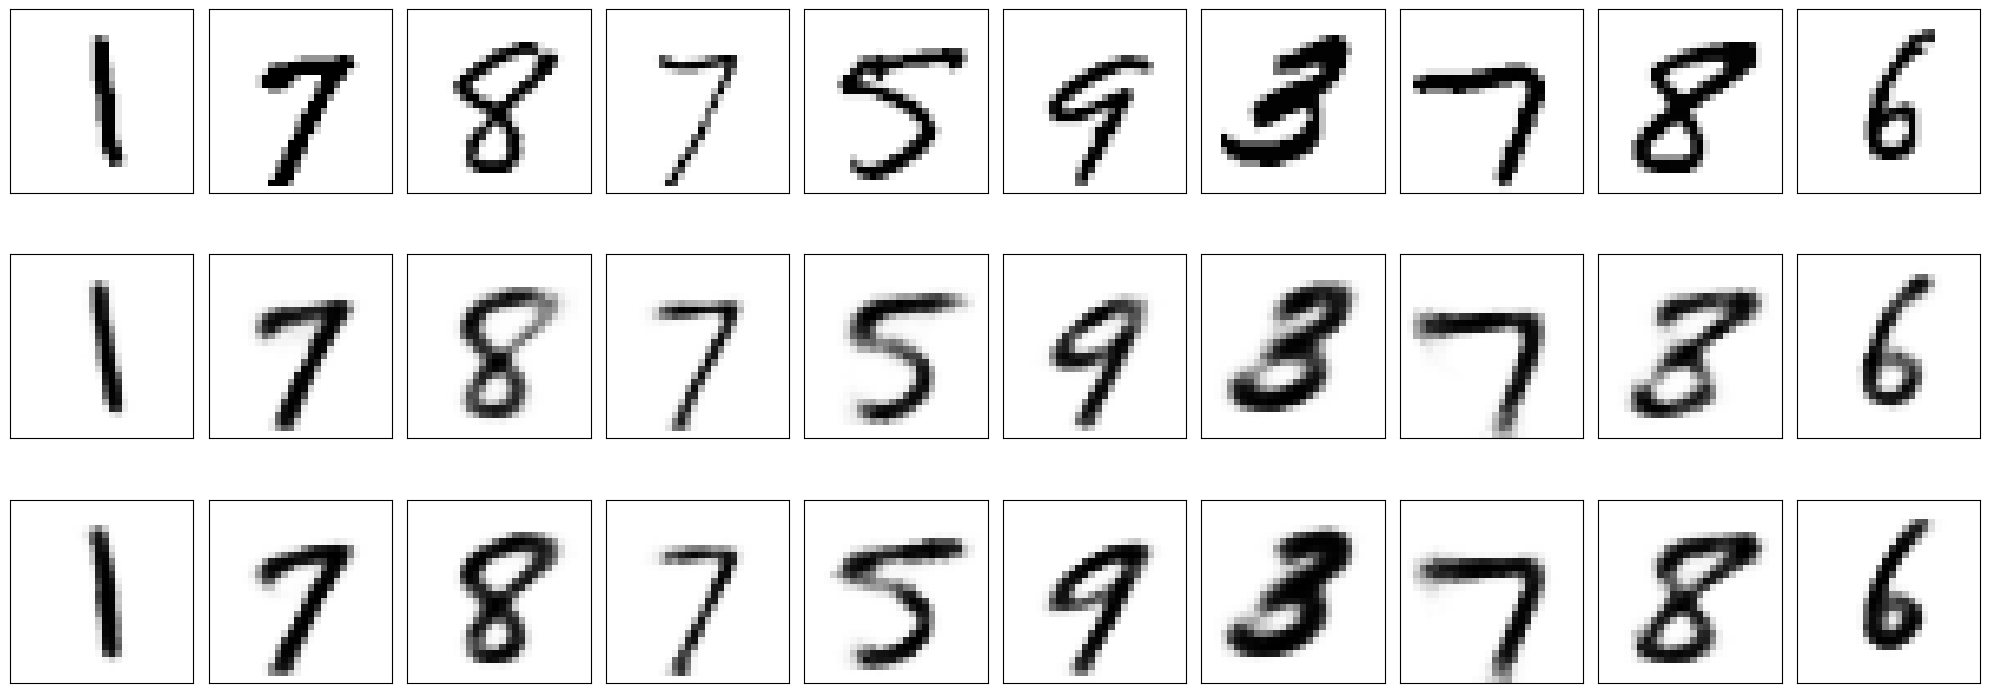

In [10]:
_, _, _, _, _, _, _, _, _, _, _, pred1, _ = model1.forward(X_test) # model1
_, _, _, _, _, _, _, _, _, _, _, pred2, _ = model2.forward(X_test) # model2

fig, ax = plt.subplots(figsize=(20,8), nrows=3, ncols=10, sharex=True, sharey=True)
ax = ax.flatten()

for i, j in enumerate(samples):
    img = X_test[j,:].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

for i, j in enumerate(samples):
    img = pred1[j,:].reshape(28, 28)
    ax[i+10].imshow(img, cmap='Greys')

for i, j in enumerate(samples):
    img = pred2[j,:].reshape(28, 28)
    ax[i+20].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [11]:
# Metric of prediction
mse1, mse2 = np.mean((pred1 - X_test) ** 2), np.mean((pred2 - X_test) ** 2)
print(f'MSE1 = {mse1:.4f} | MSE2 = {mse2:.4f}')

MSE1 = 0.0179 | MSE2 = 0.0181


# Sampling

In [12]:
n=np.random.randint(0,10000,1) #sample generation
n=3001

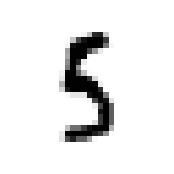

In [13]:
# original data
plt.figure(figsize=(2,2))
plt.imshow(X_test[n,:].reshape(28,28),cmap='Greys')
plt.axis('off')
plt.show()

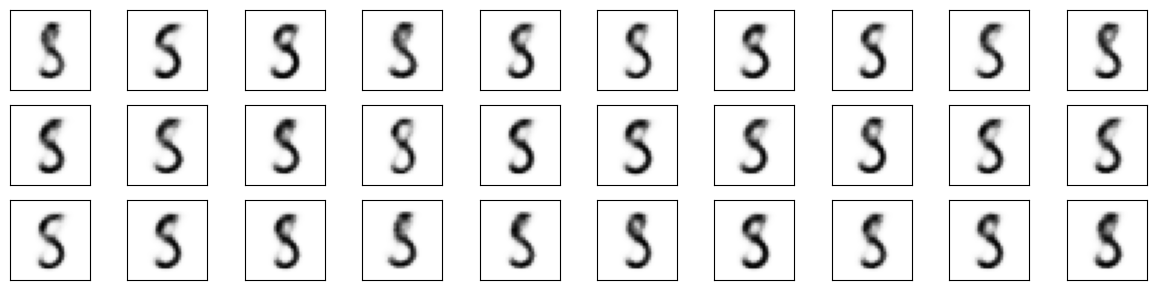

In [14]:
#VAE
fig, ax = plt.subplots(figsize=(12,3), nrows=3, ncols=10, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(30):
    _, _, _, _, _, _, _, _, _, _, _, pred, _ = model1.forward(X_test[n,:]) #VAE
    img = pred.reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

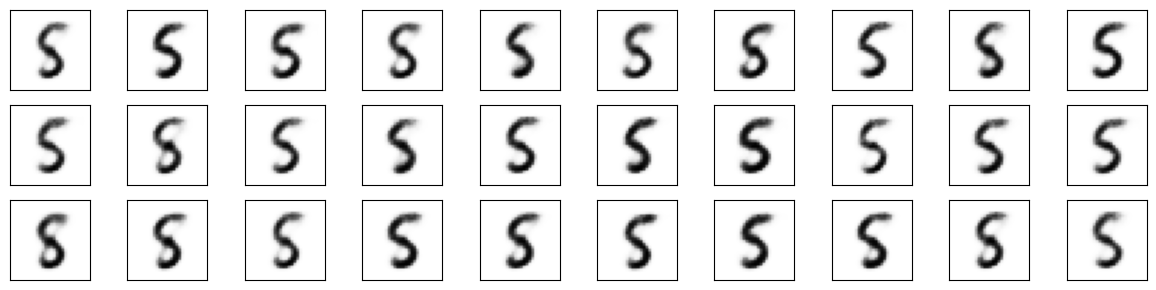

In [15]:
#t_prior_VAE
fig, ax = plt.subplots(figsize=(12,3), nrows=3, ncols=10, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(30):
    _, _, _, _, _, _, _, _, _, _, _, pred, _ = model2.forward(X_test[n,:]) #t_prior_VAE
    img = pred.reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

# make missing algorithm

In [16]:
# random masking
def make_missing(data, fraction):
    data_with_missing = data.copy()
    n_samples, n_features = data_with_missing.shape

    # Calculate the total number of elements to be replaced with 0
    n_missing = int(np.floor(fraction * n_samples * n_features))

    # Randomly choose indices to be replaced with 0
    r=np.random.RandomState(123)
    missing_indices = r.choice(n_samples * n_features, n_missing, replace=False)

    # Set the chosen indices to 0
    data_with_missing.ravel()[missing_indices] = 0
    # masking 0 or 1?
    return data_with_missing, missing_indices

In [17]:
# square random masking
def mask_random_square(data, m, k):
    n, p = data.shape
    masked_data = data.copy()
    missing_indices = []
    image_size = int(np.sqrt(p))  # Assume square images

    for i in range(n):
        # Reshape the flat image into square shape
        image = masked_data[i].reshape(image_size, image_size)
        for _ in range(k):
            # Randomly choose the top-left corner and size of the mask
            mask_size = np.random.randint(1, m + 1)
            x = np.random.randint(0, image_size - mask_size + 1)
            y = np.random.randint(0, image_size - mask_size + 1)

            # Collect indices of the masked elements in the flattened data array
            for row in range(x, x + mask_size):
                for col in range(y, y + mask_size):
                    # Index in the flattened data array
                    idx = i * p + (row * image_size + col)
                    missing_indices.append(idx)

            # Apply the mask
            image[x:x + mask_size, y:y + mask_size] = 0

        # Flatten back to 1D
        masked_data[i] = image.flatten()

    missing_indices = np.array(missing_indices)
    return masked_data, missing_indices

# VAE missing imputation(random missing)

In [18]:
X_miss, missing_indices = make_missing(X_test, fraction=0.3)

In [19]:
n=30 # of sampling

pred1_lst=list()
pred2_lst=list()
for i in range(n):
    _, _, _, _, _, _, _, _, _, _, _, pred1, _ = model1.forward(X_miss) # model1
    pred1_lst.append(pred1)
    _, _, _, _, _, _, _, _, _, _, _, pred2, _ = model2.forward(X_miss) # model2
    pred2_lst.append(pred2)

pred1_m = np.mean(pred1_lst, axis=0) #predictied mean by VAE
pred2_m = np.mean(pred2_lst, axis=0) #predictied mean by t_prior_VAE

imputed1 = X_miss.copy()
imputed1.ravel()[missing_indices] = pred1_m.flatten()[missing_indices]
imputed2 = X_miss.copy()
imputed2.ravel()[missing_indices] = pred2_m.flatten()[missing_indices]

In [20]:
samples=np.random.randint(0,10000,10)

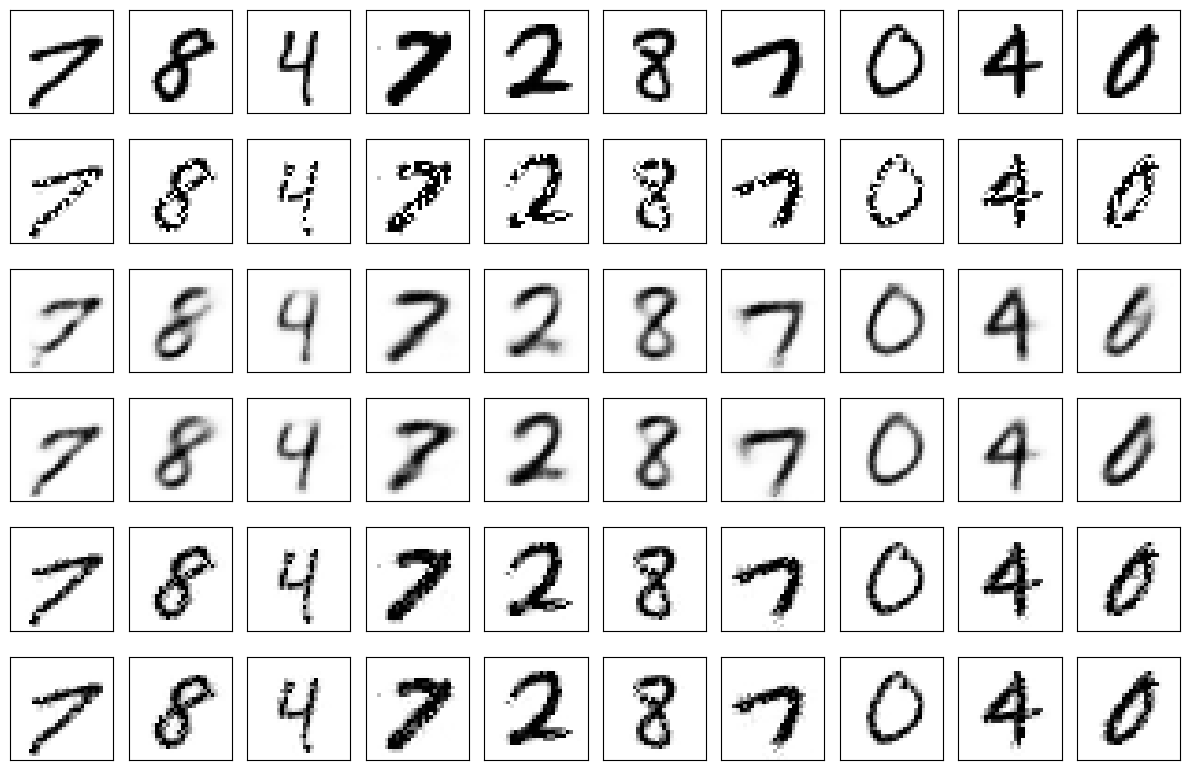

In [21]:
fig, ax = plt.subplots(figsize=(12,8), nrows=6, ncols=10, sharex=True, sharey=True)
ax = ax.flatten()

for i, j in enumerate(samples):
    img = X_test[j,:].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

for i, j in enumerate(samples):
    img = X_miss[j,:].reshape(28, 28)
    ax[i+10].imshow(img, cmap='Greys')

for i, j in enumerate(samples):
    img = pred1_m[j,:].reshape(28, 28)
    ax[i+20].imshow(img, cmap='Greys')

for i, j in enumerate(samples):
    img = pred2_m[j,:].reshape(28, 28)
    ax[i+30].imshow(img, cmap='Greys')

for i, j in enumerate(samples):
     img = imputed1[j,:].reshape(28, 28)
     ax[i+40].imshow(img, cmap='Greys')

for i, j in enumerate(samples):
     img = imputed2[j,:].reshape(28, 28)
     ax[i+50].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [22]:
# Metric of predicted mean
mse1, mse2 = np.mean((pred1_m - X_test) ** 2), np.mean((pred2_m - X_test) ** 2)
ssim1, ssim2 = ssim(pred1_m, X_test), ssim(pred2_m, X_test)
print(f'MSE1 = {mse1:.4f} | MSE2 = {mse2:.4f}')
print(f'SSIM1 = {ssim1:.4f} | SSIM2 = {ssim2:.4f}')

MSE1 = 0.0280 | MSE2 = 0.0247
SSIM1 = 0.7676 | SSIM2 = 0.8148


In [23]:
# Metric of imputation
mse1, mse2 = np.mean((imputed1 - X_test) ** 2), np.mean((imputed2 - X_test) ** 2)
ssim1, ssim2 = ssim(imputed1, X_test), ssim(imputed2, X_test)
print(f'MSE1 = {mse1:.4f} | MSE2 = {mse2:.4f}')
print(f'SSIM1 = {ssim1:.4f} | SSIM2 = {ssim2:.4f}')

MSE1 = 0.0091 | MSE2 = 0.0081
SSIM1 = 0.9443 | SSIM2 = 0.9523


# VAE missing imputation(square random missing)

In [24]:
X_miss, missing_indices = mask_random_square(X_test, 4, 50)

In [25]:
n=30 # of sampling

pred1_lst=list()
pred2_lst=list()
for i in range(n):
    _, _, _, _, _, _, _, _, _, _, _, pred1, _ = model1.forward(X_miss) # model1
    pred1_lst.append(pred1)

    _, _, _, _, _, _, _, _, _, _, _, pred2, _ = model2.forward(X_miss) # model2
    pred2_lst.append(pred2)

pred1_m = np.mean(pred1_lst, axis=0) #mean or median
pred2_m = np.mean(pred2_lst, axis=0) #mean or median

imputed1 = X_miss.copy()
imputed1.ravel()[missing_indices] = pred1_m.flatten()[missing_indices]
imputed2 = X_miss.copy()
imputed2.ravel()[missing_indices] = pred2_m.flatten()[missing_indices]

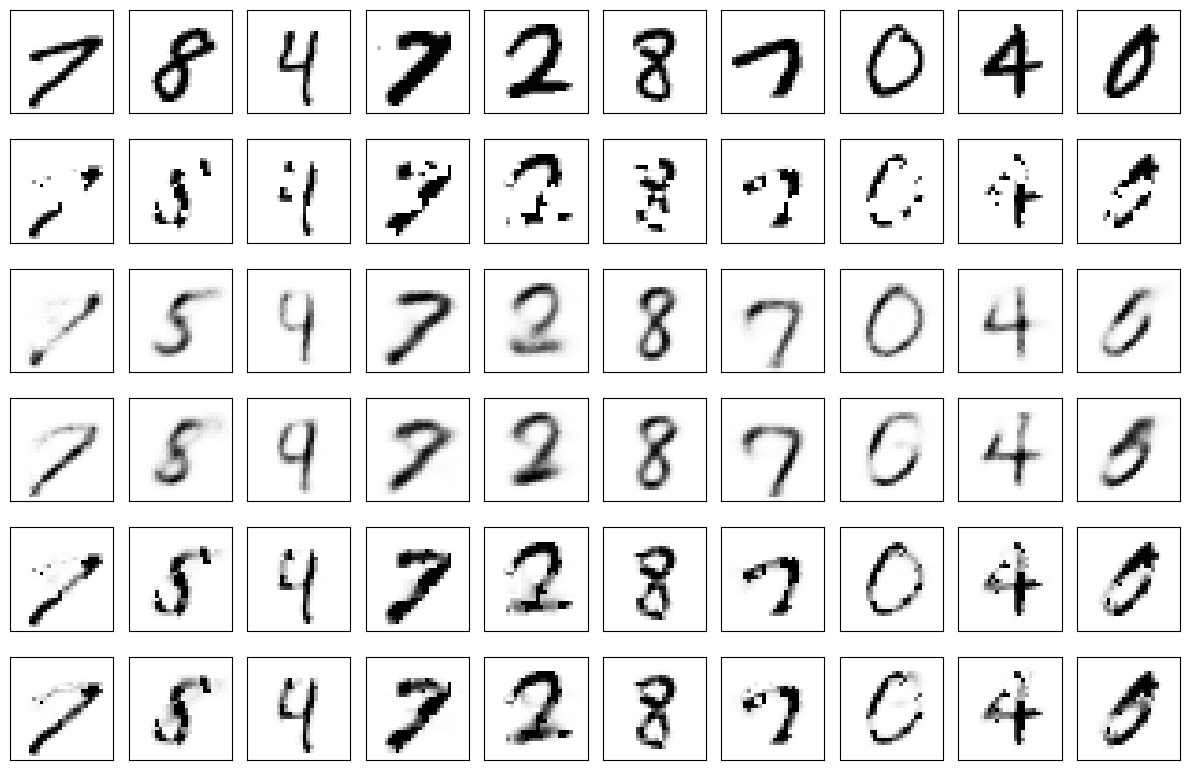

In [26]:
fig, ax = plt.subplots(figsize=(12,8), nrows=6, ncols=10, sharex=True, sharey=True)
ax = ax.flatten()

for i, j in enumerate(samples):
    img = X_test[j,:].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

for i, j in enumerate(samples):
    img = X_miss[j,:].reshape(28, 28)
    ax[i+10].imshow(img, cmap='Greys')

for i, j in enumerate(samples):
    img = pred1_m[j,:].reshape(28, 28)
    ax[i+20].imshow(img, cmap='Greys')

for i, j in enumerate(samples):
    img = pred2_m[j,:].reshape(28, 28)
    ax[i+30].imshow(img, cmap='Greys')

for i, j in enumerate(samples):
     img = imputed1[j,:].reshape(28, 28)
     ax[i+40].imshow(img, cmap='Greys')

for i, j in enumerate(samples):
     img = imputed2[j,:].reshape(28, 28)
     ax[i+50].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [27]:
# Metric of predicted mean
mse1, mse2 = np.mean((pred1_m - X_test) ** 2), np.mean((pred2_m - X_test) ** 2)
ssim1, ssim2 = ssim(pred1_m, X_test), ssim(pred2_m, X_test)
print(f'MSE1 = {mse1:.4f} | MSE2 = {mse2:.4f}')
print(f'SSIM1 = {ssim1:.4f} | SSIM2 = {ssim2:.4f}')

MSE1 = 0.0452 | MSE2 = 0.0406
SSIM1 = 0.5742 | SSIM2 = 0.6492


In [28]:
# Metric of imputation
mse1, mse2 = np.mean((imputed1 - X_test) ** 2), np.mean((imputed2 - X_test) ** 2)
ssim1, ssim2 = ssim(imputed1, X_test), ssim(imputed2, X_test)
print(f'MSE1 = {mse1:.4f} | MSE2 = {mse2:.4f}')
print(f'SSIM1 = {ssim1:.4f} | SSIM2 = {ssim2:.4f}')

MSE1 = 0.0245 | MSE2 = 0.0222
SSIM1 = 0.8244 | SSIM2 = 0.8465
